In [2]:
#####################################################
# imports
#####################################################

import os
from collections import defaultdict

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_sample_weight

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real

from xgboost import XGBClassifier

In [3]:
#####################################################
# Experimental Parameters
#
#####################################################

# data preparation 
min_prev_score = 2.5
score_threshold = 5.0
min_progression = 0.5

# feature selection
mi_threshold = 0.005
feature_selection_type = None
drop_DMO_features = False
drop_non_DMO_features = False

# undersampling
do_data_sampling = False

# bayesian search parameters
n_iter = 20
random_state = 42
verbose = 0
n_jobs = -1
cv = 5
scoring = 'recall_macro'

# cross validation
cv_folds = 5



Initially 2274 rows.
596 rows have missing EDSS values and will be dropped...


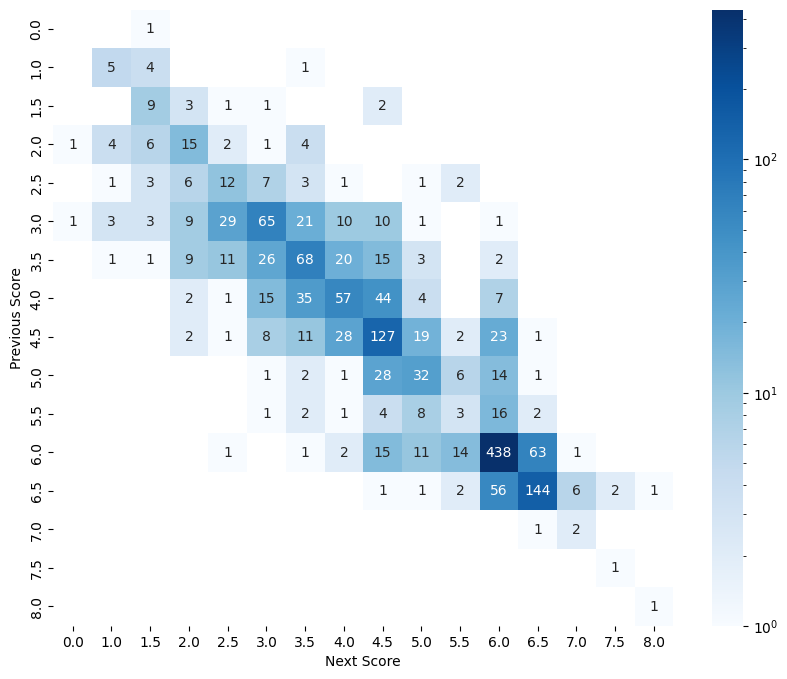

801 rows have a previous EDSS >= 5.5 and will be dropped...
60 rows have a previous EDSS < 2.5 and will be dropped...
52 rows have missing DMOs and will be dropped...
We have 56 progressions across 54 subjects, out of a total of 765 valid samples.


,Local.Participant,visit.number,age,gender,EDFSCR1L,time_since_diag,time_since_onset,Prev_EDSS,Prev_Timepoint,progression,...,ws_30_avg_w,strlen_30_avg_w,cadence_30_avg_w,strdur_30_avg_w,ws_30_p90_w,cadence_30_p90_w,ws_30_var_w,strlen_30_var_w,wb_60_sum_w,n_days_w
29,10382,T2,61.0,1,6.0,1.272356e+09,1.287476e+09,4.0,T1,1,...,0.84,106.0,94.0,1.25,1.00,103.0,17.0,16.0,7.0,7.0
41,10384,T4,57.0,1,6.0,5.790770e+08,5.814098e+08,5.0,T3,1,...,0.86,110.0,94.0,1.22,1.02,104.0,18.0,12.0,9.0,7.0
46,10385,T4,41.0,0,6.0,3.045996e+08,3.656844e+08,4.5,T3,1,...,0.96,116.0,98.0,1.16,1.12,109.0,18.0,14.0,10.0,7.0
77,10393,T5,46.0,1,6.0,3.052772e+08,8.781092e+08,4.5,T4,1,...,0.86,120.0,84.0,1.34,1.07,100.0,19.0,11.0,4.0,7.0
146,10416,T2,48.0,1,6.0,6.411276e+08,8.578188e+08,5.0,T1,1,...,0.60,87.0,76.0,1.45,1.02,98.0,54.0,34.0,9.0,7.0


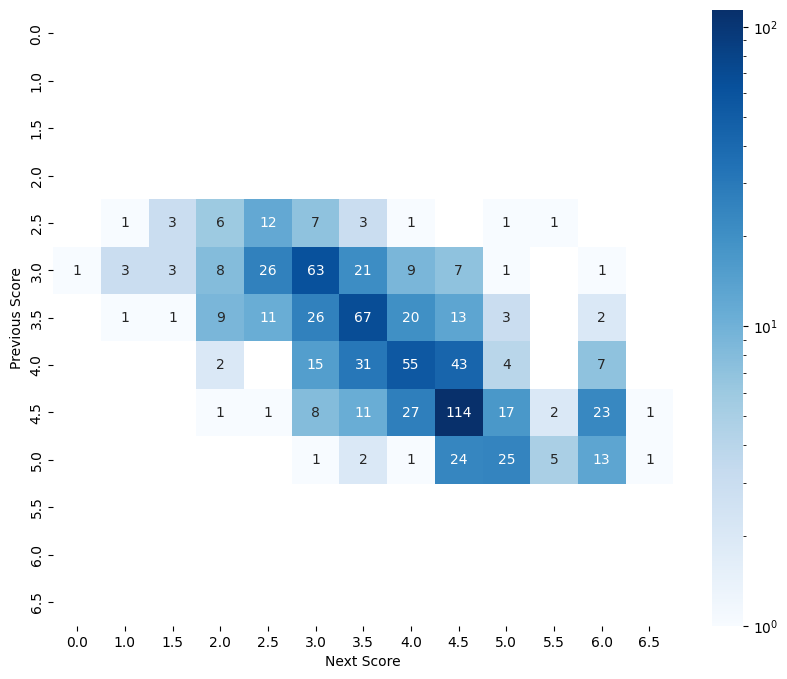

In [4]:
#####################################################
# Data preparation and exclusion
#
#####################################################

load_dotenv()


def show_transition_matrix():
    # Create matrix of prev -> next EDSS scores
    prev_scores = data['Prev_EDSS'].to_numpy().tolist()
    next_scores = data['EDFSCR1L'].to_numpy().tolist()

    # extract the unique scores
    scores = list(set(prev_scores).union(set(next_scores)))
    scores.sort()
    n_scores = len(scores)

    # Create transition matrix
    # Note some of these transitions will be for people with missing DMOs
    transition_matrix = pd.DataFrame(
        np.zeros((n_scores, n_scores), dtype=int),
        index=scores,
        columns=scores)

    for prev_score, next_score in zip(prev_scores, next_scores):
        transition_matrix.loc[prev_score, next_score] += 1

    # Pretty print transition matrix as heatmap
    plt.subplots(figsize=(10, 8))
    ax = plt.subplot(111)
    sns.heatmap(transition_matrix.values, annot=True, cmap="Blues", ax=ax, fmt='d', norm=colors.LogNorm())
    ax.set_xlabel('Next Score')
    ax.set_ylabel('Previous Score')
    ax.xaxis.set_ticklabels(scores)
    ax.yaxis.set_ticklabels(scores)
    plt.show()


data_dir = os.getenv("DATA_DIR", "Dataset/")

# read in main MS dataset
data_file_path = data_dir + r"MS_dataset_v.7.3.csv"
cols_from_dataset = ['Local.Participant', 'EDFSCR1L', 'visit.number', 'age', 'gender', 'mstypeonset', 'mstypediag',
                     'visit.date']
data = pd.read_csv(data_file_path, usecols=cols_from_dataset)

# forward fill within groups to ensure no leakage of demographics between participants
cols_from_dataset = [col for col in cols_from_dataset if col in ['age', 'gender', 'mstypeonset', 'mstypediag']]
for col in cols_from_dataset:
    data[col] = data.groupby('Local.Participant')[col].ffill()

# we need to get the time difference and convert from timedelta to something that the ML models can use - probably unix time
data['time_since_diag'] = (pd.to_datetime(data['visit.date']) - pd.to_datetime(data['mstypediag'])).dt.total_seconds()
data['time_since_onset'] = (pd.to_datetime(data['visit.date']) - pd.to_datetime(data['mstypeonset'])).dt.total_seconds()

# drop cols used for calculation
data = data.drop(['mstypeonset', 'mstypediag', 'visit.date'], axis=1)

# convert gender to 0 and 1
data['gender'] = data['gender'].map({'Male': 0, 'Female': 1})

# Crop down to just the necessary columns
data = data.sort_values(by=['Local.Participant', 'visit.number'])

# shift timepoints and EDSS to get previous as columns
data['Prev_EDSS'] = data.groupby('Local.Participant')['EDFSCR1L'].shift(1)
data['Prev_Timepoint'] = data.groupby('Local.Participant')['visit.number'].shift(1)

# get progression label column
progression_mask = (
        (data['Prev_EDSS'] < score_threshold) &
        (data['EDFSCR1L'] >= score_threshold) &
        ((data['EDFSCR1L'] - data['Prev_EDSS']) >= min_progression)
)
data['progression'] = np.where(progression_mask, 1, 0)

transitions = data[progression_mask]  # all the data where a transition happens, just in case.

data['Prev_Timepoint'] = data['Prev_Timepoint'].str.upper()  # needed for later merges
data['visit.number'] = data['visit.number'].str.upper()  # this one is just for consistency

#display(transitions.head(10))

# now that we have a reduced dataset, loop through our weekly dmo aggregations and append the relevant ones to the dataframe
timepoints = ["T1", "T2", "T3", "T4"]  # we don't need DMOs where T5 is previous

dfs_list = []
for timepoint in timepoints:
    feature_file_path = data_dir + f"/{timepoint} Aggregated DMO Data_V7.3/cvs-{timepoint}-weekly_agg_all-21-01-2026.csv"
    temp_df = pd.read_csv(feature_file_path)
    dfs_list.append(temp_df)

features_df = pd.concat(dfs_list, ignore_index=True)
data = pd.merge(data, features_df, left_on=['Local.Participant', 'Prev_Timepoint'],
                right_on=['participant_id', 'visit_type'], how='left')

data = data.drop(['participant_id', 'visit_type'], axis=1)
data = data.dropna(subset=['Prev_Timepoint'])

# Data cleaning - will monitor number of rows throughout
print(f"Initially {len(data)} rows.")

# get rid of participants where either current or previous EDSS is missing
count_before = len(data)
data = data.dropna(subset=['EDFSCR1L', 'Prev_EDSS'])
print(f"{count_before - len(data)} rows have missing EDSS values and will be dropped...")

show_transition_matrix()

# Exclude participants with Prev_EDSS >= threshold as they have already progressed:
count_before = len(data)
high_prev_edss_mask = (data['Prev_EDSS'] >= score_threshold)
print(f"{sum(high_prev_edss_mask)} rows have a previous EDSS >= {score_threshold} and will be dropped...")
data = data.drop(data[high_prev_edss_mask].index)

# Exclude participants with Prev_EDSS < min_prev_score as they are highly unlikely to progress, and may have different mobility patterns
count_before = len(data)
low_prev_edss_mask = (data['Prev_EDSS'] < min_prev_score)
print(f"{sum(low_prev_edss_mask)} rows have a previous EDSS < {min_prev_score} and will be dropped...")
data = data.drop(data[low_prev_edss_mask].index)

# drop all remaining NAN rows, which will be due to missing DMOs
count_before = len(data)
data = data.dropna()
print(f"{count_before - len(data)} rows have missing DMOs and will be dropped...")

num_progressions = len(data[data["progression"] == 1])
unique_sub_progressions = len(data[data["progression"] == 1]['Local.Participant'].unique())

print(
    f"We have {num_progressions} progressions across {unique_sub_progressions} subjects, out of a total of {len(data)} valid samples.")

display(data[data["progression"] == 1].head(5))

show_transition_matrix()
#labels_df.to_csv("data.csv", index=False)

# need to be at least 1 (not 0.5) to change
# subset of EDSS and normalise?
# balance dataset - Done very good

# undersampled_df = labels_df.groupby('progression').sample(labels_df.groupby('progression').size().min())

strdur_30_avg_w      0.144791
time_since_diag      0.122340
strdur_all_avg_w     0.100990
time_since_onset     0.094013
Prev_EDSS            0.070900
age                  0.052779
cadence_all_var_w    0.032002
gender               0.026231
wbdur_all_avg_w      0.013771
wb_10_sum_w         -0.005081
ws_30_var_w         -0.008070
wb_30_sum_w         -0.008495
wb_all_sum_w        -0.024239
strlen_30_var_w     -0.026682
walkdur_all_sum_w   -0.035483
wb_60_sum_w         -0.037778
wbsteps_all_sum_w   -0.039396
cadence_all_avg_w   -0.042834
strdur_all_var_w    -0.058310
cadence_30_avg_w    -0.070715
wbdur_all_p90_w     -0.084659
cadence_30_p90_w    -0.101700
n_days_w            -0.141376
wbdur_all_var_w     -0.150626
strlen_1030_avg_w   -0.156603
strlen_30_avg_w     -0.156969
ws_30_avg_w         -0.157339
ws_1030_avg_w       -0.160004
ws_30_p90_w         -0.181557
ws_10_p90_w         -0.197649
dtype: float64

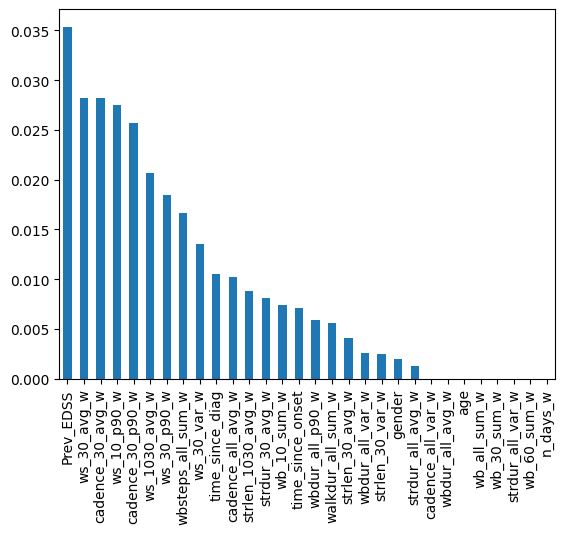

Removed irrelevant (i.e. MI == 0) features


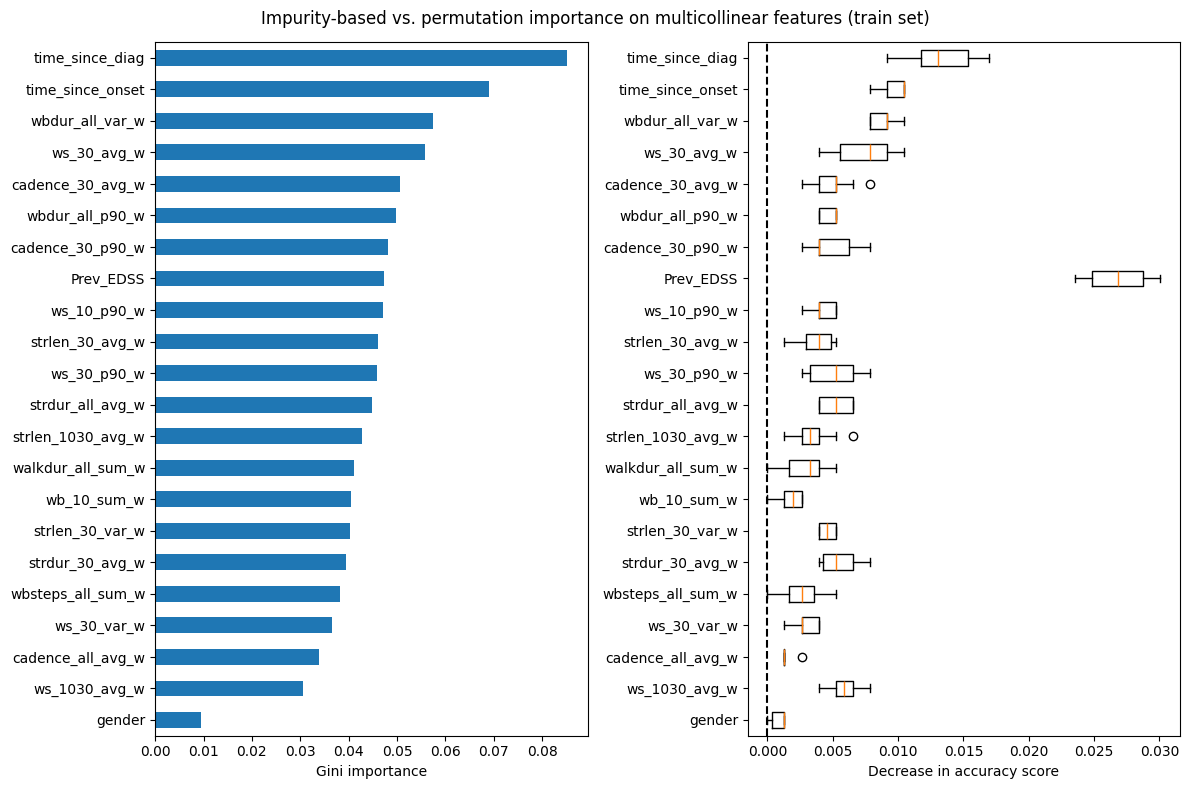

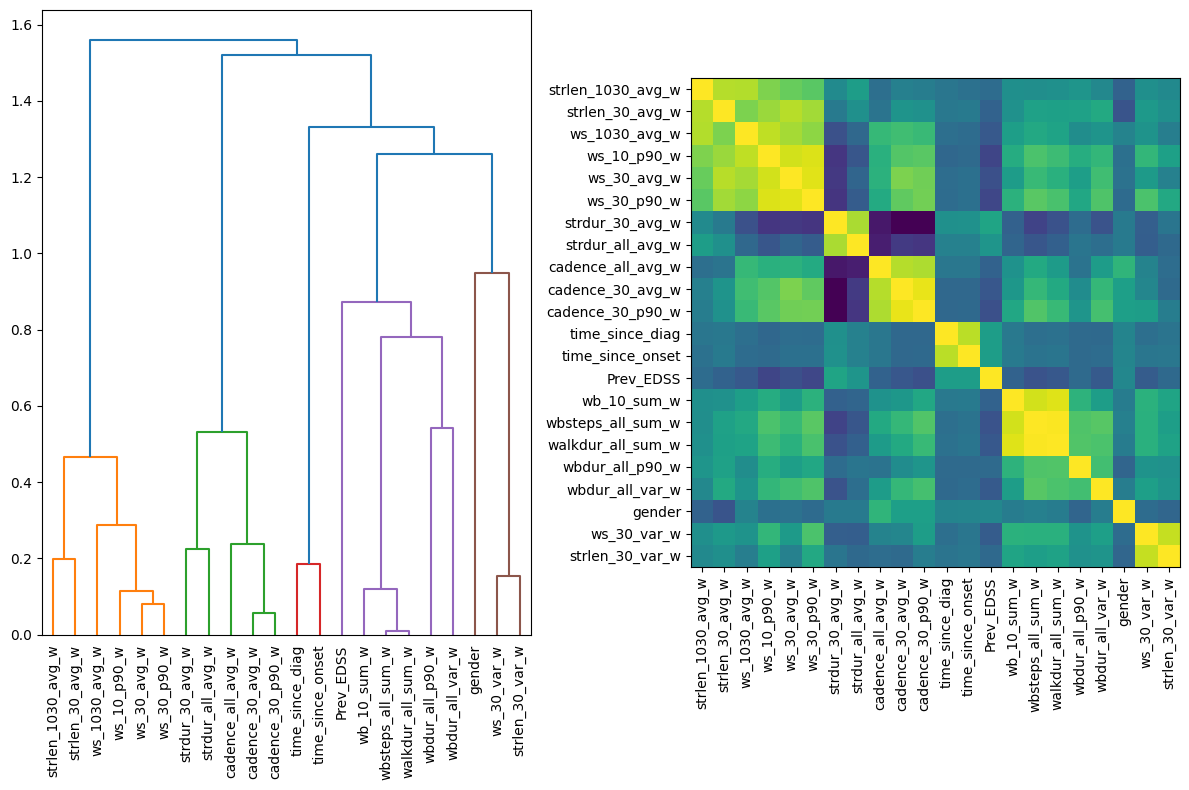

Baseline accuracy on test data: 0.93
Baseline accuracy on test data with features removed: 0.93


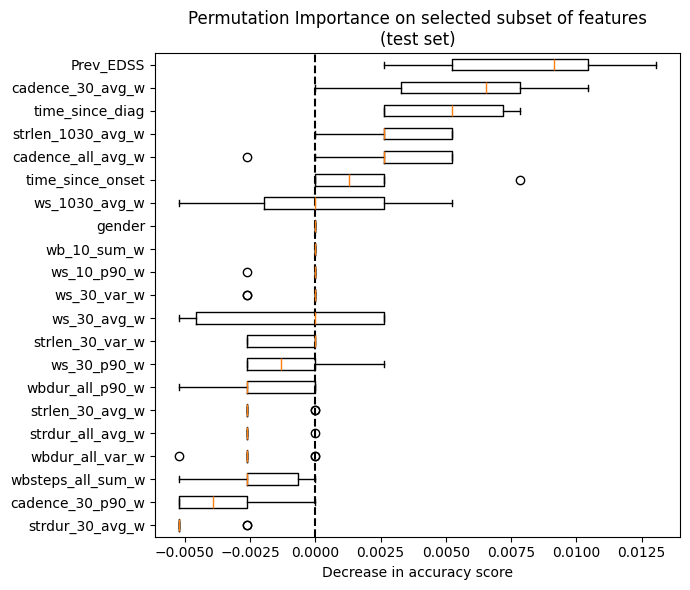

Explained variance: [0.32197368 0.2744514  0.09235302 0.08373808 0.06833187 0.05358023
 0.0313924  0.02090979 0.01496277]
Cumulative: [0.32197368 0.59642508 0.6887781  0.77251618 0.84084805 0.89442828
 0.92582068 0.94673047 0.96169324]
Shape of Original Dataset: (765, 22)
Shape after PCA: (765, 9)


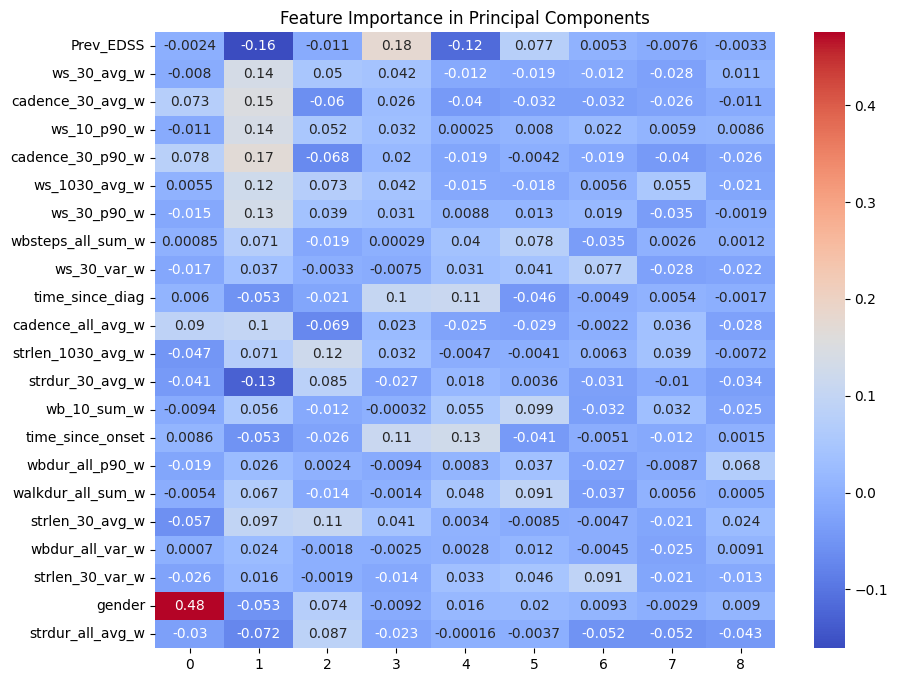

Feature selection: None
X_data shape: (765, 22)


In [5]:
###################################################################
# Feature selection and exclusion
# Note that in data preparation rows with NaN values are excluded.
# Removing these features (columns) may increase the data,
# if that feature is the reason for NaN exclusion.
# ToDo Test with various thresholds
###################################################################


def rf_feature_analysis(X, y, random_state=42):
    model = RandomForestRegressor(random_state=random_state)
    model.fit(X, y)

    # The importance of a feature is how much this feature is used in each tree of the forest.
    # It is computed as the (normalized) total reduction of the criterion brought by that feature.
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

    fig, ax = plt.subplots()
    importances = pd.Series(model.feature_importances_, index=np.array(X.columns))
    importances = pd.Series(data=importances, index=X.columns).sort_values(ascending=False)
    importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importance using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()


def rf_perm_feature_analysis(X, y, random_state=42):
    model = RandomForestClassifier(random_state=random_state)
    model.fit(X, y)

    result = permutation_importance(model, X, y, n_repeats=10, random_state=random_state, n_jobs=2)

    fig, ax = plt.subplots()
    importances = pd.Series(result.importances_mean, index=np.array(X.columns))
    importances = pd.Series(data=importances, index=X.columns).sort_values(ascending=False)
    importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importance using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()


def plot_permutation_importance(clf, X, y, ax, indexes=None, random_state=42):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=random_state, n_jobs=2)
    if indexes is not None:
        perm_sorted_idx = indexes
    else:
        perm_sorted_idx = result.importances_mean.argsort()

    tick_labels_dict = {"tick_labels": X.columns[perm_sorted_idx]}
    ax.boxplot(result.importances[perm_sorted_idx].T, vert=False, **tick_labels_dict)
    ax.axvline(x=0, color="k", linestyle="--")
    return ax


def rf_combine_feature_analysis(X, y, random_state=42):
    clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
    clf.fit(X, y)

    mdi_importances = pd.Series(clf.feature_importances_, index=X.columns)
    tree_importance_sorted_idx = np.argsort(clf.feature_importances_)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    mdi_importances.sort_values().plot.barh(ax=ax1)
    ax1.set_xlabel("Gini importance")
    plot_permutation_importance(clf, X, y, ax2, tree_importance_sorted_idx)
    ax2.set_xlabel("Decrease in accuracy score")
    fig.suptitle(
        "Impurity-based vs. permutation importance on multicollinear features (train set)"
    )
    _ = fig.tight_layout()
    plt.show()


def mi_feature_analysis(X, y, mi_threshold=0.0, random_state=42):
    # feature importance analysis
    pearson_corr = X.corrwith(y).sort_values(ascending=False)
    display(pearson_corr)

    # mutual information gain for feature removal
    mi = mutual_info_classif(X, y, random_state=random_state, n_jobs=-1)
    mi = pd.Series(data=mi, index=X.columns).sort_values(ascending=False)
    mi.plot(kind='bar')
    plt.show()

    # delete features with 0 information gain
    mi = mi[mi > mi_threshold]

    X = X[mi.index]

    return X


def show_correlation(X):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    corr = spearmanr(X).correlation

    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    # We convert the correlation matrix to a distance matrix before performing
    # hierarchical clustering using Ward's linkage.
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    dendro = hierarchy.dendrogram(
        dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
    )
    dendro_idx = np.arange(0, len(dendro["ivl"]))

    ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
    ax2.set_xticks(dendro_idx)
    ax2.set_yticks(dendro_idx)
    ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
    ax2.set_yticklabels(dendro["ivl"])
    _ = fig.tight_layout()
    plt.show()

    return dist_linkage


def cluster_selection(X, y, dist_linkage, threshold=0.05, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, train_size=0.5)

    clf = RandomForestClassifier(n_estimators=100, random_state=random_state)
    clf.fit(X_train, y_train)
    print(f"Baseline accuracy on test data: {clf.score(X_test, y_test):.2}")

    cluster_ids = hierarchy.fcluster(dist_linkage, threshold, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
    selected_features_names = X.columns[selected_features]

    X_train_sel = X_train[selected_features_names]
    X_test_sel = X_test[selected_features_names]

    clf_sel = RandomForestClassifier(n_estimators=100, random_state=random_state)
    clf_sel.fit(X_train_sel, y_train)
    print(
        "Baseline accuracy on test data with features removed:"
        f" {clf_sel.score(X_test_sel, y_test):.2}"
    )

    fig, ax = plt.subplots(figsize=(7, 6))
    plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
    ax.set_title("Permutation Importance on selected subset of features\n(test set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()
    plt.show()

    return X[selected_features_names]


def pca_selection(X, random_state=42):
    # normalisation
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=0.95, svd_solver='full', random_state=random_state)  # keep 95% of variance
    X_pca = pd.DataFrame(data=pca.fit_transform(X_scaled))
    print("Explained variance:", pca.explained_variance_ratio_)
    print("Cumulative:", np.cumsum(pca.explained_variance_ratio_))
    print("Shape of Original Dataset:", X_scaled.shape)
    print("Shape after PCA:", X_pca.shape)

    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    plt.figure(figsize=(10, 8))
    sns.heatmap(loadings, annot=True, cmap='coolwarm', yticklabels=np.array(X.columns))
    plt.title('Feature Importance in Principal Components')
    plt.show()

    return X_pca


# drop irrelevant or 'cheating' columns
y_data = data["progression"].reset_index(drop=True)  # can be data["progression"] or data["multiclass_progression"]
labels_X_all = data.reset_index(drop=True)

if (drop_DMO_features):
    X_data = data[['Prev_EDSS', 'age', 'gender', 'time_since_diag', 'time_since_onset']].reset_index(drop=True)
else:
    features_to_drop = ["progression", "Local.Participant", "EDFSCR1L", "visit.number", "Prev_Timepoint"]
    if (drop_non_DMO_features):
        features_to_drop += ['Prev_EDSS', 'age', 'gender', 'time_since_diag', 'time_since_onset']
    X_data = data.drop(features_to_drop, axis=1)

# remove any feature with an MI pf 0
X_data = mi_feature_analysis(X_data, y_data, mi_threshold=0)
print("Removed irrelevant (i.e. MI == 0) features")

# rf_feature_analysis(X_data, y_data)
# rf_perm_feature_analysis(X_data, y_data)
rf_combine_feature_analysis(X_data, y_data)

dist_linkage = show_correlation(X_data)
X_data_cluster = cluster_selection(X_data, y_data, dist_linkage)

X_data_pca = pca_selection(X_data)

if (feature_selection_type == "cluster"):
    X_data = X_data_cluster
elif (feature_selection_type == "mi"):
    if (mi_threshold > 0):
        X_data = mi_feature_analysis(X_data, y_data, mi_threshold=mi_threshold)
elif (feature_selection_type == "pca"):
    X_data = X_data_pca
elif (feature_selection_type is not None):
    print("Feature selection type not recognized")

print("Feature selection:", feature_selection_type)
print("X_data shape:", X_data.shape)

In [6]:
######################################################################
# Resampling data (NOT USED)
# Note this needs to be tidied up into the experimentation framework
######################################################################


def get_unsampled(x_data, x_sampled, y_data):
    # Create dataframe with column showing whether data has been sampled or not
    # Shown by column "_merge" value "both" == sampled "left_only" == not sampled
    merged = x_data.merge(x_sampled.drop_duplicates(), how='left', indicator=True)
    # Get indices of rows which have not been sampled
    unsampled_indices = merged.index[merged['_merge'] == "left_only"].tolist()
    X_unsampled = X_data.iloc[unsampled_indices]
    y_unsampled = y_data.iloc[unsampled_indices]
    return X_unsampled, y_unsampled


if (do_data_sampling):
    rus = RandomUnderSampler(random_state=42)
    ros = RandomOverSampler(random_state=42)
    smote = SMOTE(random_state=42)
    adasyn = ADASYN(random_state=42)

    X_data, y_data = smote.fit_resample(X_data, y_data)


In [7]:
######################################################################
# Machine learning models
#
######################################################################

# Note need to remove 'poly' as an option from the SVC kernel to make it work on small data sets.
# See https://github.com/scikit-learn/scikit-learn/issues/4648
svm_model = BayesSearchCV(
    SVC(random_state=42),
    {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),  # Regularization parameter
        'gamma': Real(1e-6, 1e+1, prior='log-uniform'),  # Kernel coefficient
        'kernel': Categorical(['rbf', 'sigmoid']),  # Type of kernel
        'degree': Integer(1, 5)  # Degree for poly kernel
    },
    n_iter=n_iter,
    random_state=random_state,
    verbose=verbose,
    n_jobs=n_jobs,
    cv=cv,
    scoring=scoring
)

mlp_model = BayesSearchCV(
    MLPClassifier(random_state=random_state, max_iter=1000),
    {
        'hidden_layer_sizes': Integer(1, 128),  # Different architectures
        'activation': Categorical(['tanh', 'relu']),
        'solver': Categorical(['sgd', 'adam']),
        'alpha': Real(1e-5, 1e-1, prior='log-uniform'),  # L2 penalty (regularization)
        'learning_rate': Categorical(['constant', 'adaptive']),
        'learning_rate_init': Real(1e-4, 1e-1, prior='log-uniform')  # Initial learning rate
    },
    n_iter=n_iter,
    random_state=random_state,
    verbose=verbose,
    n_jobs=n_jobs,
    cv=cv,
    scoring=scoring
)

knn_model = BayesSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors': Integer(1, 50),
        'weights': Categorical(['uniform', 'distance']),
        'algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size': Integer(10, 50),
        'p': Integer(1, 2)  # 1 = Manhattan, 2 = Euclidean distance
    },
    n_iter=n_iter,
    random_state=random_state,
    verbose=verbose,
    n_jobs=n_jobs,
    cv=cv,
    scoring=scoring
)

xgb_model = BayesSearchCV(
    XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss'),
    {
        'n_estimators': Integer(50, 500),
        'max_depth': Integer(3, 10),
        'learning_rate': Real(0.01, 1.0, prior='log-uniform'),
        'subsample': Real(0.5, 1.0, prior='uniform'),  # Fraction of samples used for fitting
        'colsample_bytree': Real(0.5, 1.0, prior='uniform'),  # Fraction of features used per tree
        'gamma': Real(1e-6, 5, prior='log-uniform'),  # Min loss reduction for split
        'reg_alpha': Real(1e-5, 10, prior='log-uniform'),  # L1 regularization
        'reg_lambda': Real(1e-5, 10, prior='log-uniform')  # L2 regularization
    },
    n_iter=n_iter,
    random_state=random_state,
    verbose=verbose,
    n_jobs=n_jobs,
    cv=cv,
    scoring=scoring
)

rf_model = BayesSearchCV(
    RandomForestClassifier(random_state=random_state),
    {
        'n_estimators': Integer(50, 500),
        'max_depth': Integer(5, 50),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 10),
        'max_features': Categorical(['sqrt', 'log2', None]),  # Number of features to consider at each split
        'bootstrap': Categorical([True, False]),
        'criterion': Categorical(['gini', 'entropy'])
    },
    n_iter=n_iter,
    random_state=random_state,
    verbose=verbose,
    n_jobs=n_jobs,
    cv=cv,
    scoring=scoring
)

dt_model = BayesSearchCV(
    DecisionTreeClassifier(random_state=random_state),
    {
        'criterion': Categorical(['gini', 'entropy']),
        'max_depth': Integer(3, 30),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 20),
        'max_features': Categorical(['sqrt', 'log2', None]),
        'ccp_alpha': Real(0.0, 0.1, prior='uniform')  # Cost-Complexity Pruning alpha
    },
    n_iter=n_iter,
    random_state=random_state,
    verbose=verbose,
    n_jobs=n_jobs,
    cv=cv,
    scoring=scoring
)

lr_model = BayesSearchCV(
    LogisticRegression(random_state=random_state, solver='saga', max_iter=5000),
    {
        'C': Real(1e-6, 1e+6, prior='log-uniform'),  # Inverse of regularization strength
        'penalty': Categorical(['l1', 'l2', 'elasticnet']),
        'l1_ratio': Real(0, 1, prior='uniform'),  # Only used if penalty='elasticnet'
        'fit_intercept': Categorical([True, False])
    },
    n_iter=n_iter,
    random_state=random_state,
    verbose=verbose,
    n_jobs=n_jobs,
    cv=cv,
    scoring=scoring
)

Best Parameters: OrderedDict({'C': 272.38144248903177, 'degree': 4, 'gamma': 0.0008100022051656554, 'kernel': 'sigmoid'})
Best Score: 0.7770791284997157
Accuracy: 0.66

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.66      0.78       142
           1       0.13      0.64      0.21        11

    accuracy                           0.66       153
   macro avg       0.54      0.65      0.50       153
weighted avg       0.90      0.66      0.74       153



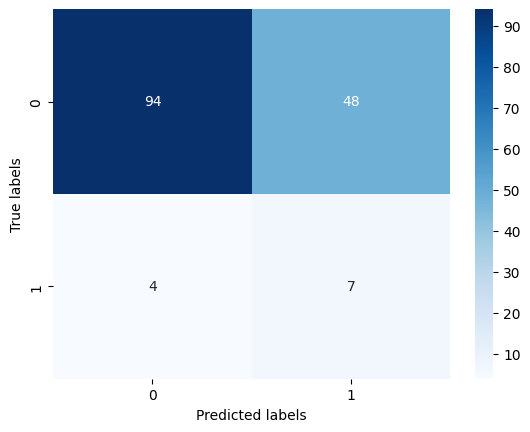

Fold 0
Accuracy: 0.63
Precision: 0.55
Recall: 0.68
F1 Score: 0.49
Fold 1
Accuracy: 0.73
Precision: 0.55
Recall: 0.65
F1 Score: 0.53
Fold 2
Accuracy: 0.82
Precision: 0.62
Recall: 0.82
F1 Score: 0.64
Fold 3
Accuracy: 0.64
Precision: 0.56
Recall: 0.72
F1 Score: 0.51
Fold 4
Accuracy: 0.76
Precision: 0.60
Recall: 0.80
F1 Score: 0.61


{'Accuracy': np.float64(0.7176470588235294),
 'Precision': np.float64(0.1721311475409836),
 'Recall': np.float64(0.75),
 'F1 Score': np.float64(0.28)}

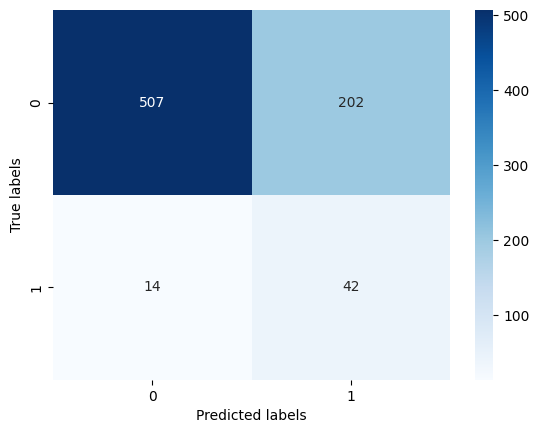

In [8]:
######################################################################
# TEST Classification / Prediction
# Note this needs to be tidied up into the experimentation framework
######################################################################

#import faulthandler
#import signal

#faulthandler.register(signal.SIGINT.value) # I'm not sure what this was doing but it wasn't working for me

# Data normalisation (Not the impact of this needs to be tested)
# e.g. StandardScaler, MinMaxScaler, RobustScaler
# If columns have different (e.g. skewed) distributions that may need different normalisations
# e.g. Log normalisation
# Note that StandardScaler combined with small data will hang SVC, MinMaxScaler works
scaler = MinMaxScaler()

def do_cv(model, X_data, y_data, n_splits=cv_folds):
    # requires: set_config(transform_output="pandas")
    # transformer = ColumnTransformer([('standard_scaler', ss, feature_cols)],
    #                                 remainder='passthrough',
    #                                 verbose_feature_names_out=False)

    combined_cm = None
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    for i, (train_split_indices, test_split_indices) in enumerate(kf.split(X_data, y_data)):

        X_train_split = X_data.iloc[train_split_indices]
        X_test_split = X_data.iloc[test_split_indices]
        y_train_split = y_data.iloc[train_split_indices]
        y_test_split = y_data.iloc[test_split_indices]

        X_train_scaled = scaler.fit_transform(X_train_split)
        X_test_scaled = scaler.transform(X_test_split)

        # sample weighting
        sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_split)

        # we need this to deal with the KNN not accepting sample weights
        try:
            model.fit(X_train_scaled, y_train_split, sample_weight=sample_weights)
        except:
            print("Sample weighting not accepted, training without...")
            model.fit(X_train_scaled, y_train_split)
        y_pred = model.predict(X_test_scaled)

        print(f"Fold {i}")
        print(f"Accuracy: {accuracy_score(y_test_split, y_pred):.2f}")
        print(f"Precision: {precision_score(y_test_split, y_pred, average='macro', zero_division=0):.2f}")
        print(f"Recall: {recall_score(y_test_split, y_pred, average='macro', zero_division=0):.2f}")
        print(f"F1 Score: {f1_score(y_test_split, y_pred, average='macro', zero_division=0):.2f}")

        cm = confusion_matrix(y_test_split, y_pred)
        if combined_cm is None:
            combined_cm = cm
        else:
            combined_cm = combined_cm + cm

    return combined_cm


def display_cm(cm):
    # Pretty print confusion matrix
    ax = plt.subplot()

    cm = pd.DataFrame(cm, range(2), range(2))
    sns.heatmap(cm, annot=True, cmap="Blues", ax=ax, fmt='d')

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])
    plt.show()


def show_evaluation(model, X_test, y_test):
    y_pred = model.predict(X_test)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    display_cm(cm)


def get_metrics_from_cm(cm):
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score
    }


# train test split
X_train, X_test, y_train, y_test = (
    train_test_split(X_data, y_data, stratify=y_data, test_size=0.2, random_state=42))

# scale the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# sample weighting
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

model = svm_model

model.fit(X_train, y_train, sample_weight=sample_weights)
# Print the best parameters
print(f"Best Parameters: {model.best_params_}")
print(f"Best Score: {model.best_score_}")
#model = model.best_estimator_  # gets the best estimator so we're not doing bayesian searching again on each fold
show_evaluation(model, X_test, y_test)

# Annoyingly cross_val_score and cross_val_predict can differ ???
conf_mat = do_cv(model, X_data, y_data)
display(get_metrics_from_cm(conf_mat))
display_cm(conf_mat)

Best Parameters: OrderedDict({'C': 272.38144248903177, 'degree': 4, 'gamma': 0.0008100022051656554, 'kernel': 'sigmoid'})
Best Score: 0.7770791284997157
Accuracy: 0.66

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.66      0.78       142
           1       0.13      0.64      0.21        11

    accuracy                           0.66       153
   macro avg       0.54      0.65      0.50       153
weighted avg       0.90      0.66      0.74       153



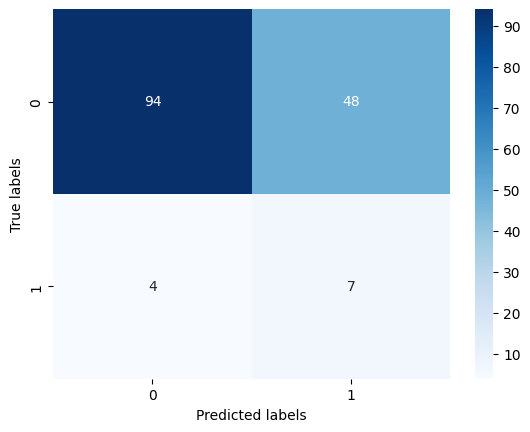

Fold 0
Accuracy: 0.63
Precision: 0.55
Recall: 0.68
F1 Score: 0.49
Fold 1
Accuracy: 0.73
Precision: 0.55
Recall: 0.65
F1 Score: 0.53
Fold 2
Accuracy: 0.82
Precision: 0.62
Recall: 0.82
F1 Score: 0.64
Fold 3
Accuracy: 0.64
Precision: 0.56
Recall: 0.72
F1 Score: 0.51
Fold 4
Accuracy: 0.76
Precision: 0.60
Recall: 0.80
F1 Score: 0.61


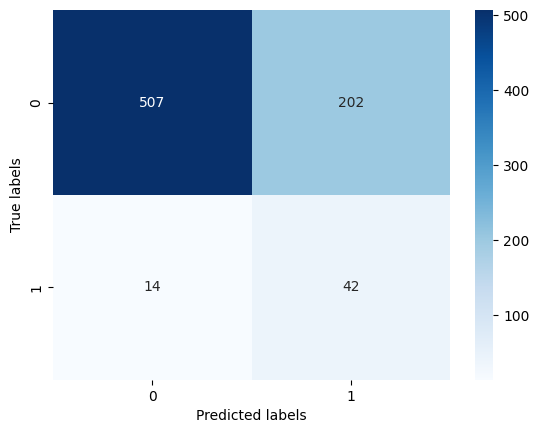

Best Parameters: OrderedDict({'activation': 'relu', 'alpha': 0.004400314189227354, 'hidden_layer_sizes': 39, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010425241256952422, 'solver': 'sgd'})
Best Score: 0.7756870051234286
Accuracy: 0.73

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.73      0.84       142
           1       0.17      0.73      0.28        11

    accuracy                           0.73       153
   macro avg       0.57      0.73      0.56       153
weighted avg       0.91      0.73      0.80       153



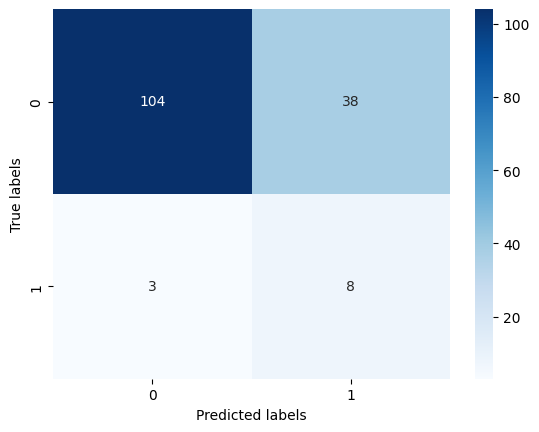

Fold 0
Accuracy: 0.67
Precision: 0.57
Recall: 0.74
F1 Score: 0.53
Fold 1
Accuracy: 0.87
Precision: 0.54
Recall: 0.55
F1 Score: 0.55
Fold 2
Accuracy: 0.84
Precision: 0.63
Recall: 0.79
F1 Score: 0.65
Fold 3
Accuracy: 0.73
Precision: 0.55
Recall: 0.65
F1 Score: 0.53
Fold 4
Accuracy: 0.80
Precision: 0.61
Recall: 0.78
F1 Score: 0.62


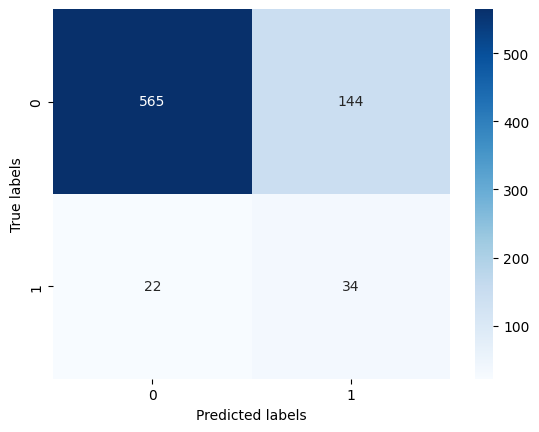

Best Parameters: OrderedDict({'algorithm': 'ball_tree', 'leaf_size': 50, 'n_neighbors': 1, 'p': 2, 'weights': 'distance'})
Best Score: 0.5811390570822337
Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       142
           1       0.14      0.09      0.11        11

    accuracy                           0.90       153
   macro avg       0.54      0.52      0.53       153
weighted avg       0.87      0.90      0.88       153



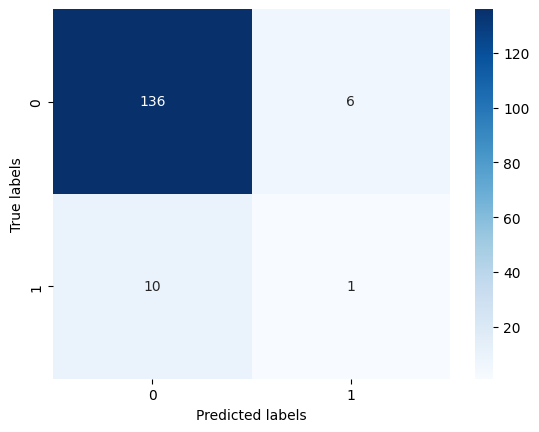

Sample weighting not accepted, training without...
Fold 0
Accuracy: 0.88
Precision: 0.55
Recall: 0.56
F1 Score: 0.55
Sample weighting not accepted, training without...
Fold 1
Accuracy: 0.86
Precision: 0.54
Recall: 0.55
F1 Score: 0.54
Sample weighting not accepted, training without...
Fold 2
Accuracy: 0.92
Precision: 0.66
Recall: 0.62
F1 Score: 0.64
Sample weighting not accepted, training without...
Fold 3
Accuracy: 0.88
Precision: 0.52
Recall: 0.51
F1 Score: 0.51
Sample weighting not accepted, training without...
Fold 4
Accuracy: 0.90
Precision: 0.61
Recall: 0.57
F1 Score: 0.58


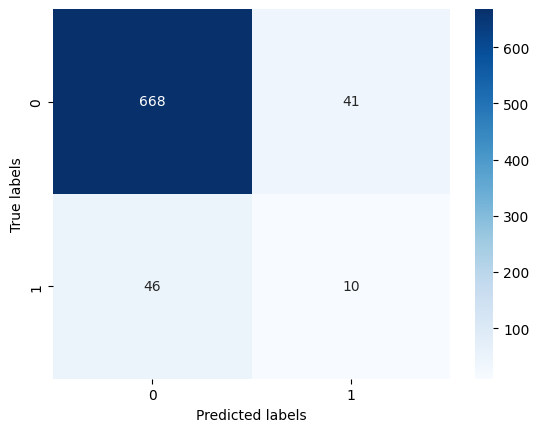

C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\xgboost\training.py:200: UserWarning: [16:39:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: OrderedDict({'colsample_bytree': 0.9603345474624708, 'gamma': 4.999999999999999, 'learning_rate': 0.1345056422881576, 'max_depth': 6, 'n_estimators': 151, 'reg_alpha': 0.029868817444786446, 'reg_lambda': 10.0, 'subsample': 0.9659826015649124})
Best Score: 0.7337059462816337
Accuracy: 0.72

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.75      0.83       142
           1       0.10      0.36      0.16        11

    accuracy                           0.72       153
   macro avg       0.52      0.56      0.49       153
weighted avg       0.88      0.72      0.78       153



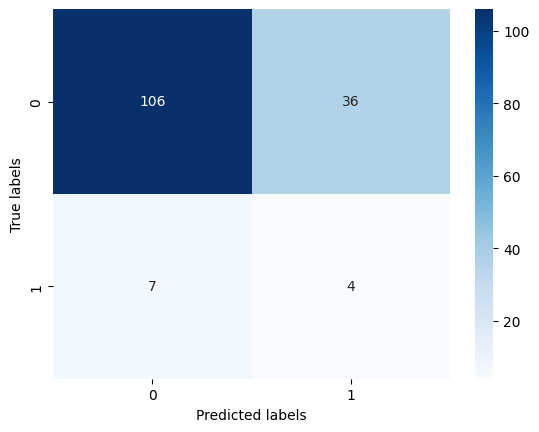

C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\xgboost\training.py:200: UserWarning: [16:39:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 0
Accuracy: 0.87
Precision: 0.61
Recall: 0.68
F1 Score: 0.63


C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\xgboost\training.py:200: UserWarning: [16:40:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 1
Accuracy: 0.75
Precision: 0.53
Recall: 0.57
F1 Score: 0.51


C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\xgboost\training.py:200: UserWarning: [16:40:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 2
Accuracy: 0.80
Precision: 0.61
Recall: 0.81
F1 Score: 0.62


C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\xgboost\training.py:200: UserWarning: [16:41:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 3
Accuracy: 0.73
Precision: 0.57
Recall: 0.73
F1 Score: 0.56


C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\xgboost\training.py:200: UserWarning: [16:41:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Fold 4
Accuracy: 0.78
Precision: 0.59
Recall: 0.73
F1 Score: 0.59


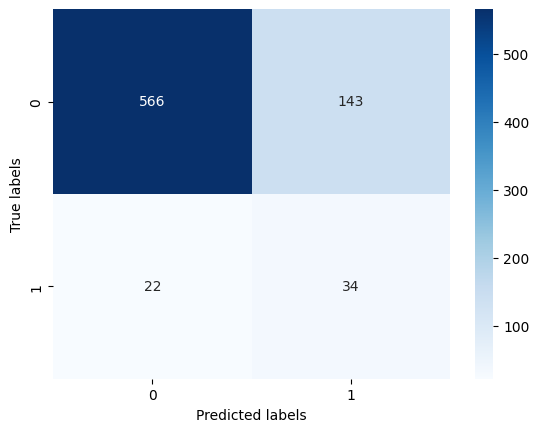

Best Parameters: OrderedDict({'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 338})
Best Score: 0.7046576618537497
Accuracy: 0.65

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.66      0.78       142
           1       0.11      0.55      0.18        11

    accuracy                           0.65       153
   macro avg       0.53      0.60      0.48       153
weighted avg       0.89      0.65      0.74       153



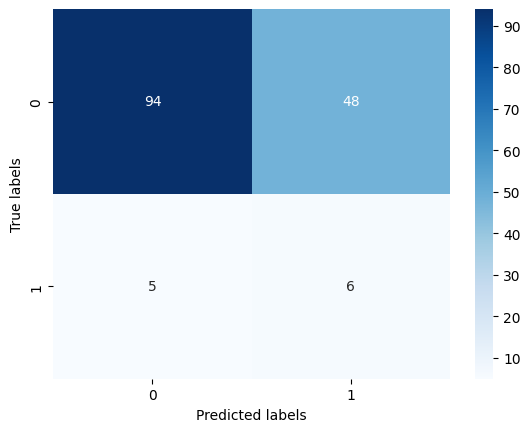

Fold 0
Accuracy: 0.61
Precision: 0.53
Recall: 0.62
F1 Score: 0.47
Fold 1
Accuracy: 0.71
Precision: 0.50
Recall: 0.51
F1 Score: 0.47
Fold 2
Accuracy: 0.84
Precision: 0.60
Recall: 0.70
F1 Score: 0.62
Fold 3
Accuracy: 0.71
Precision: 0.55
Recall: 0.67
F1 Score: 0.53
Fold 4
Accuracy: 0.87
Precision: 0.57
Recall: 0.59
F1 Score: 0.58


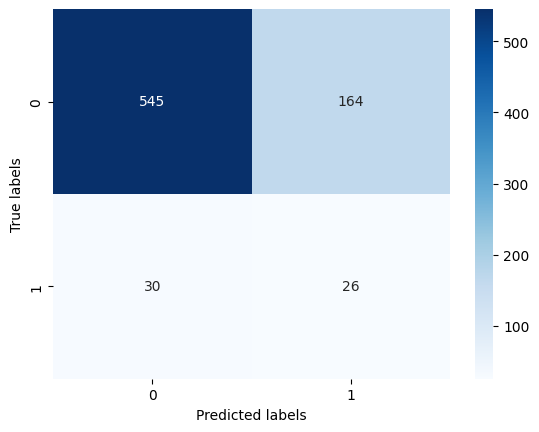

Best Parameters: OrderedDict({'ccp_alpha': 0.03655838088343226, 'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 20})
Best Score: 0.7668374476013045
Accuracy: 0.70

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.72      0.82       142
           1       0.11      0.45      0.18        11

    accuracy                           0.70       153
   macro avg       0.53      0.59      0.50       153
weighted avg       0.88      0.70      0.77       153



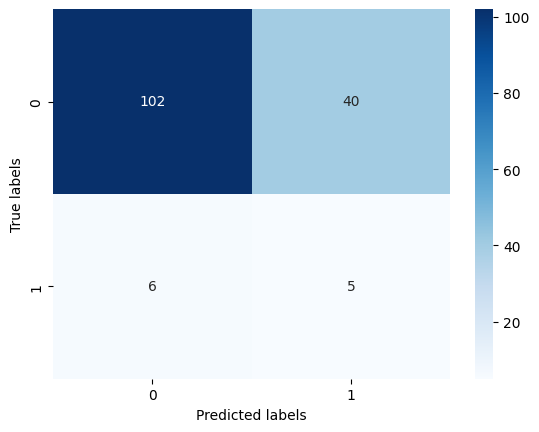

Fold 0
Accuracy: 0.48
Precision: 0.55
Recall: 0.68
F1 Score: 0.41
Fold 1
Accuracy: 0.66
Precision: 0.53
Recall: 0.61
F1 Score: 0.49
Fold 2
Accuracy: 0.80
Precision: 0.62
Recall: 0.85
F1 Score: 0.64
Fold 3
Accuracy: 0.65
Precision: 0.56
Recall: 0.73
F1 Score: 0.51
Fold 4
Accuracy: 0.75
Precision: 0.59
Recall: 0.75
F1 Score: 0.58


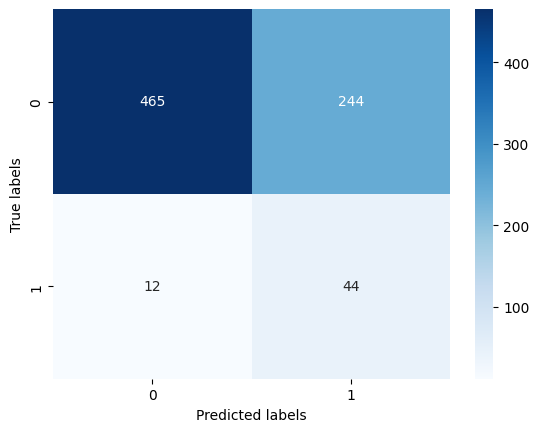

Best Parameters: OrderedDict({'C': 0.038053884115508974, 'fit_intercept': False, 'l1_ratio': 0.08191210660682714, 'penalty': 'elasticnet'})
Best Score: 0.7765797236453971
Accuracy: 0.71

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.71      0.82       142
           1       0.16      0.73      0.27        11

    accuracy                           0.71       153
   macro avg       0.57      0.72      0.54       153
weighted avg       0.91      0.71      0.78       153



C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


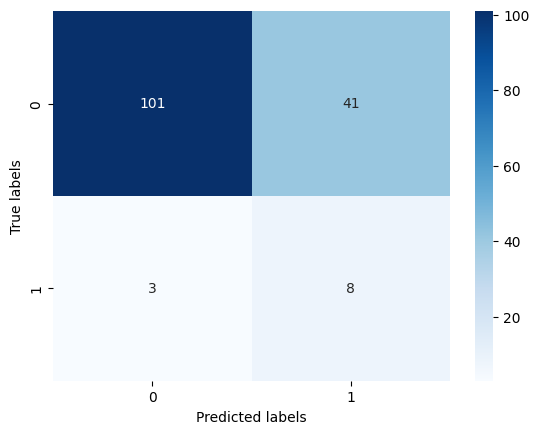

C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\sklearn\linear_model\_logistic.py:1152: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.9328679988478339. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Fold 0
Accuracy: 0.61
Precision: 0.57
Recall: 0.75
F1 Score: 0.50


C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Fold 1
Accuracy: 0.76
Precision: 0.56
Recall: 0.66
F1 Score: 0.56


C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Fold 2
Accuracy: 0.81
Precision: 0.64
Recall: 0.90
F1 Score: 0.66


C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\sklearn\linear_model\_logistic.py:1152: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l2 with l1_ratio=0.14967982298385096. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Fold 3
Accuracy: 0.68
Precision: 0.55
Recall: 0.66
F1 Score: 0.51


C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\sklearn\linear_model\_logistic.py:1152: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.5264495823337367. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


Fold 4
Accuracy: 0.77
Precision: 0.61
Recall: 0.80
F1 Score: 0.61


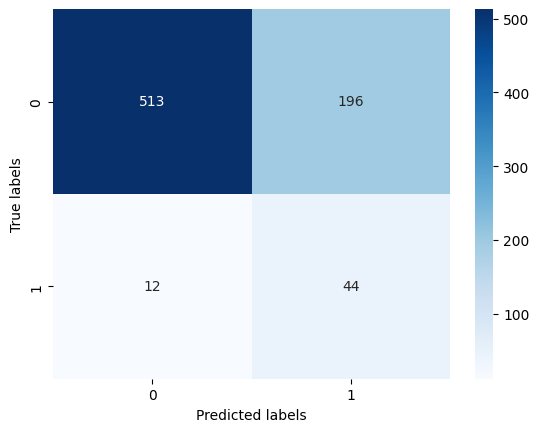

,Accuracy,Precision,Recall,F1 Score
Model,,,,
Logistic Regression,0.728105,0.183333,0.785714,0.297297
Decision Tree,0.665359,0.152778,0.785714,0.255814
SVM,0.717647,0.172131,0.750000,0.280000
XGBoost,0.784314,0.192090,0.607143,0.291845
MLP,0.783007,0.191011,0.607143,0.290598
Random Forest,0.746405,0.136842,0.464286,0.211382
KNN,0.886275,0.196078,0.178571,0.186916


In [9]:
# all models in one dict with names
models_dict = {
    "SVM": svm_model,
    "MLP": mlp_model,
    "KNN": knn_model,
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Decision Tree": dt_model,
    "Logistic Regression": lr_model
}

model_performance = []

for name, model in models_dict.items():
    if not name == "KNN":
        model.fit(X_train, y_train, sample_weight=sample_weights)
    else:
        model.fit(X_train, y_train)

    print(f"Best Parameters: {model.best_params_}")
    print(f"Best Score: {model.best_score_}")
    show_evaluation(model, X_test, y_test)

    conf_mat = do_cv(model, X_data, y_data)
    metrics = get_metrics_from_cm(conf_mat)
    metrics["Model"] = name
    model_performance.append(metrics)
    display_cm(conf_mat)

performance_df = pd.DataFrame(model_performance)
cols = ['Model'] + [c for c in performance_df.columns if c != 'Model']
performance_df = performance_df[cols]
performance_df.set_index('Model', inplace=True)
performance_df = performance_df.sort_values(by='Recall', ascending=False)

display(performance_df)

In [10]:
# un-normalise the data and try to find out which samples were misclassified
best_model_name = performance_df.sort_values(by='Recall', ascending=False).iloc[0].name
print(best_model_name)
best_model = models_dict[best_model_name]

if not best_model_name == "KNN":
    best_model.fit(X_train, y_train, sample_weight=sample_weights)
else:
    best_model.fit(X_train, y_train)

train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_test)

indexed_train_predictions = y_train.reset_index()
indexed_train_predictions["Prediction"] = train_predictions
indexed_train_predictions.index = indexed_train_predictions["index"]
indexed_train_predictions = indexed_train_predictions.drop(["index"], axis=1)

indexed_test_predictions = y_test.reset_index()
indexed_test_predictions["Prediction"] = test_predictions
indexed_test_predictions.index = indexed_test_predictions["index"]
indexed_test_predictions = indexed_test_predictions.drop(["index"], axis=1)

predictions_to_be_appended = pd.concat([indexed_train_predictions, indexed_test_predictions], axis=0)
#predictions_to_be_appended = indexed_test_predictions
predictions_to_be_appended["misclassified"] = abs(
    predictions_to_be_appended["Prediction"] - predictions_to_be_appended["progression"])
predictions_to_be_appended["correctly_classified"] = 1 - predictions_to_be_appended["misclassified"]
predictions_to_be_appended = predictions_to_be_appended.drop(["progression"], axis=1)

original_data_with_predictions = labels_X_all.join(predictions_to_be_appended)

display(original_data_with_predictions[original_data_with_predictions["misclassified"] == 1].head(5))

Logistic Regression


C:\Users\ac4jmi\anaconda3\envs\mobgap_fixed\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,Local.Participant,visit.number,age,gender,EDFSCR1L,time_since_diag,time_since_onset,Prev_EDSS,Prev_Timepoint,progression,...,strdur_30_avg_w,ws_30_p90_w,cadence_30_p90_w,ws_30_var_w,strlen_30_var_w,wb_60_sum_w,n_days_w,Prediction,misclassified,correctly_classified
1,10378,T4,52.0,1,4.5,2.436684e+08,2.455692e+08,5.0,T3,0,...,1.09,0.86,106.0,24.0,14.0,0.0,7.0,1,1,0
2,10378,T5,52.0,1,4.5,2.585434e+08,2.604442e+08,4.5,T4,0,...,1.22,0.69,97.0,22.0,15.0,0.0,7.0,1,1,0
4,10379,T3,37.0,0,4.5,1.501087e+08,5.631871e+08,4.5,T2,0,...,1.28,1.10,99.0,23.0,17.0,9.0,5.0,1,1,0
10,10381,T5,61.0,1,4.5,2.158586e+08,2.195738e+08,4.5,T4,0,...,1.25,1.03,107.0,18.0,11.0,9.0,7.0,1,1,0
11,10382,T2,61.0,1,6.0,1.272356e+09,1.287476e+09,4.0,T1,1,...,1.25,1.00,103.0,17.0,16.0,7.0,7.0,0,1,0


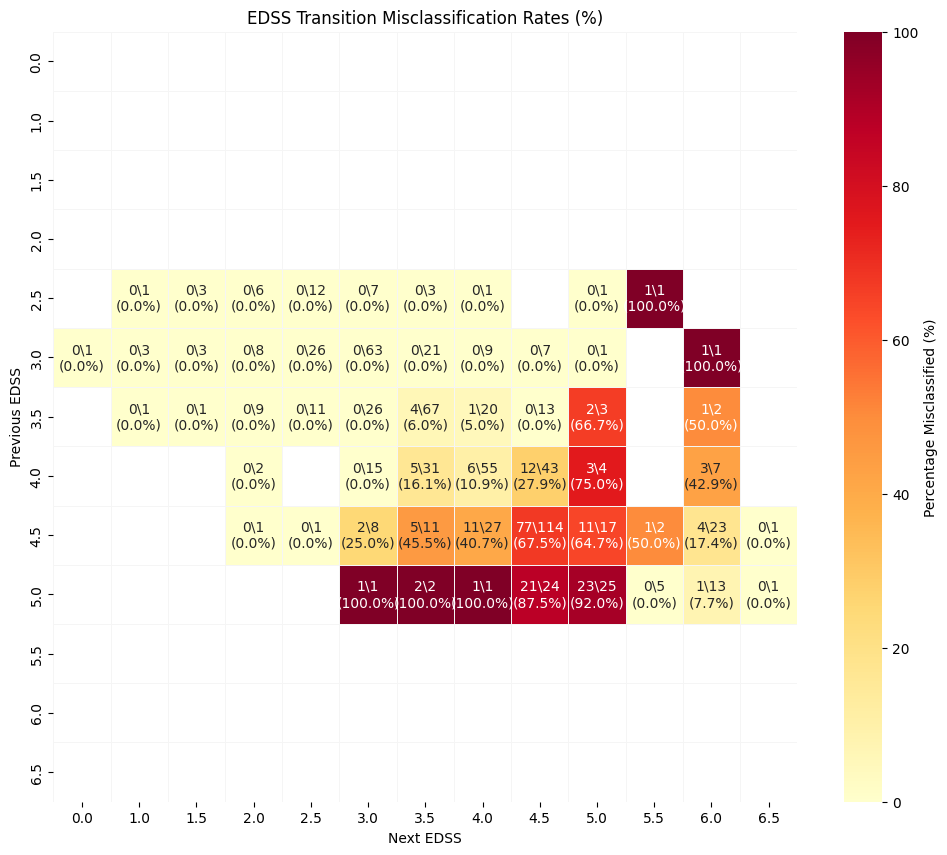

In [11]:
scores = sorted(list(set(original_data_with_predictions['Prev_EDSS']).union(
    set(original_data_with_predictions['EDFSCR1L']))))

error_matrix = original_data_with_predictions.pivot_table(
    index='Prev_EDSS',
    columns='EDFSCR1L',
    values='misclassified',
    aggfunc='sum',
    fill_value=0
).reindex(index=scores, columns=scores, fill_value=0)

total_matrix = original_data_with_predictions.pivot_table(
    index='Prev_EDSS',
    columns='EDFSCR1L',
    values='Prediction',  # Any column works here for counting
    aggfunc='count',
    fill_value=0
).reindex(index=scores, columns=scores, fill_value=0)

percentage_matrix = (error_matrix / total_matrix) * 100
percentage_matrix = percentage_matrix.fillna(0)  # Clean up NaNs where total was 0

annot_labels = np.array([
    [f"{int(count)}\\{int(total)}\n({pct:.1f}%)" if total > 0 else ""
     for count, pct, total in zip(count_row, pct_row, total_row)]
    for count_row, pct_row, total_row in zip(error_matrix.values, percentage_matrix.values, total_matrix.values)
])

mask = (total_matrix == 0)

plt.figure(figsize=(12, 10))

sns.heatmap(
    percentage_matrix,
    annot=annot_labels,
    fmt='',
    mask=mask,
    cmap="YlOrRd",
    cbar_kws={'label': 'Percentage Misclassified (%)'},
    linewidths=.5,
    linecolor='whitesmoke'
)

plt.title('EDSS Transition Misclassification Rates (%)')
plt.xlabel('Next EDSS')
plt.ylabel('Previous EDSS')
plt.show()

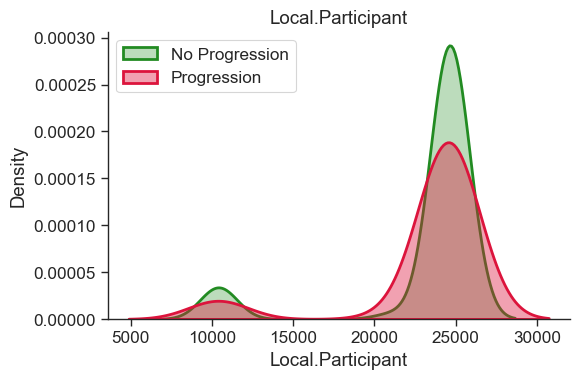

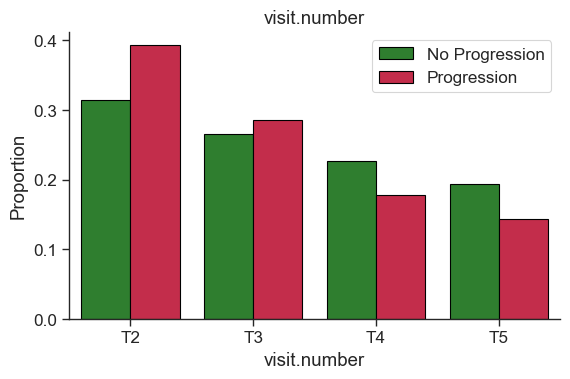

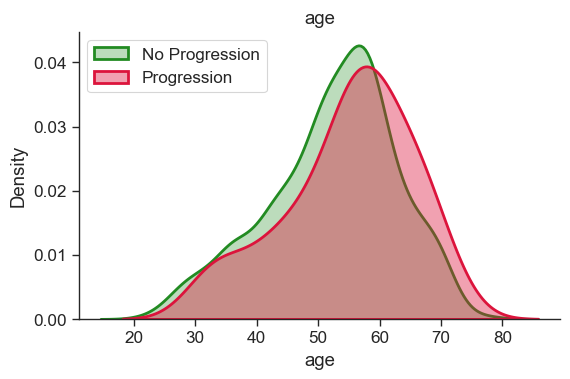

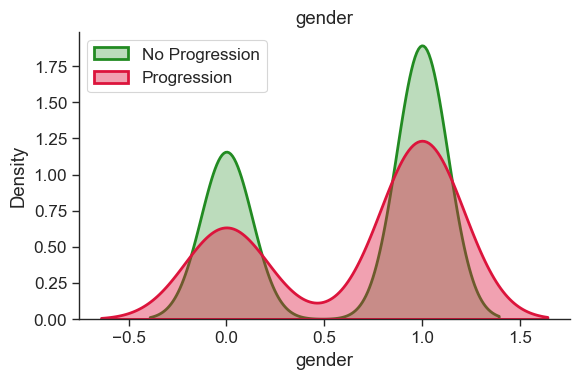

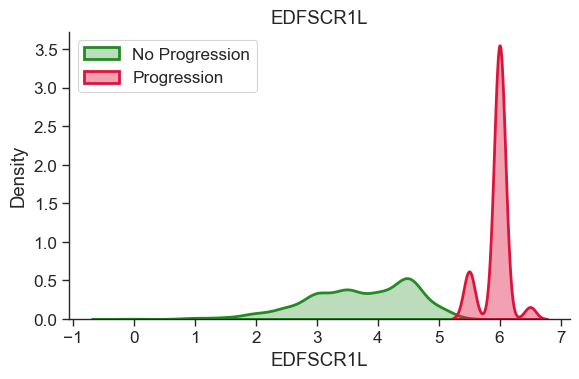

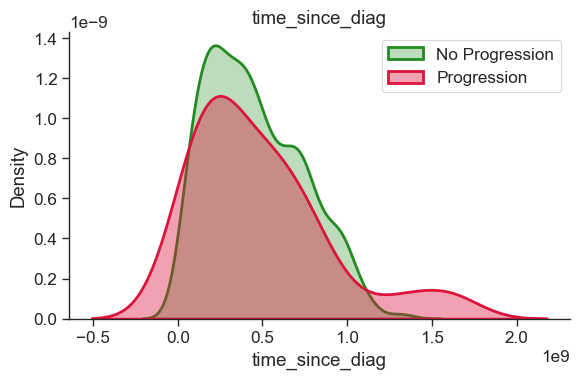

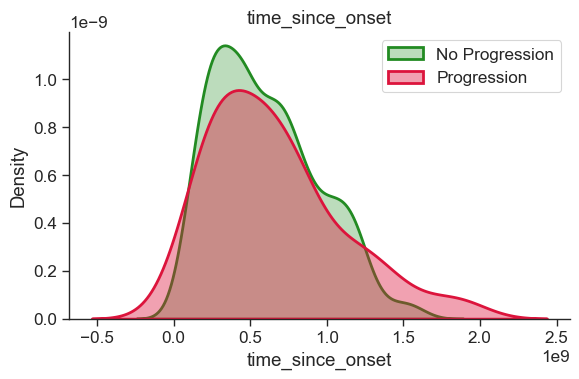

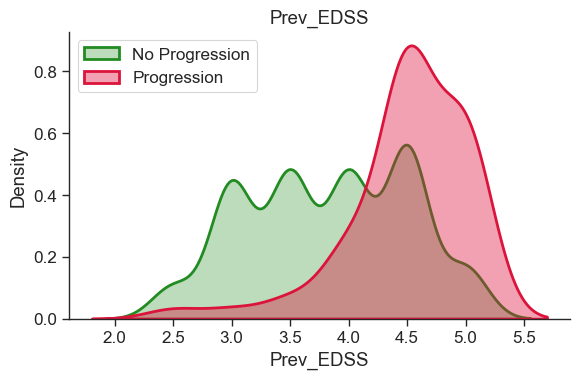

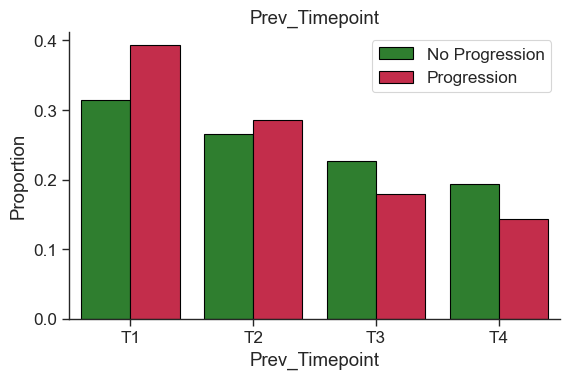

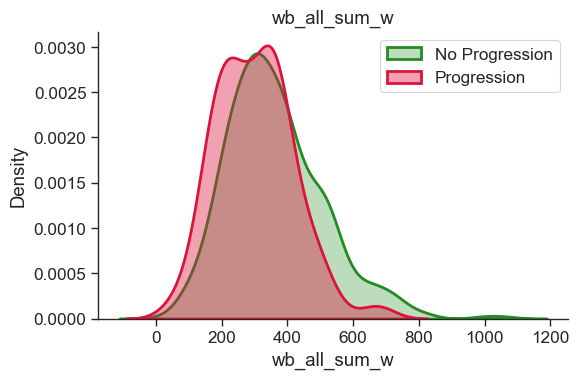

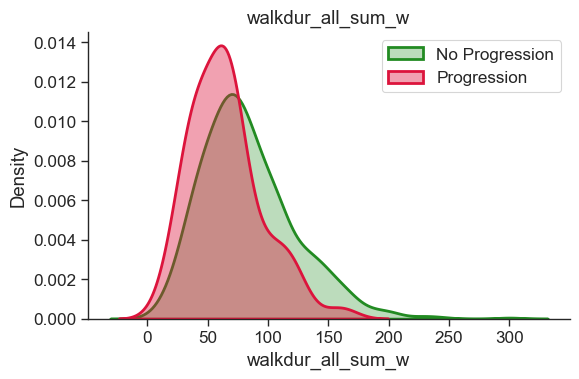

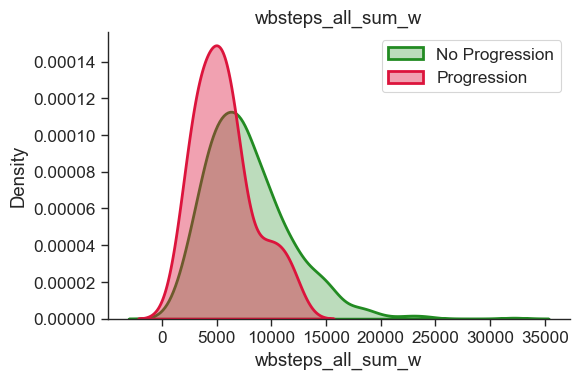

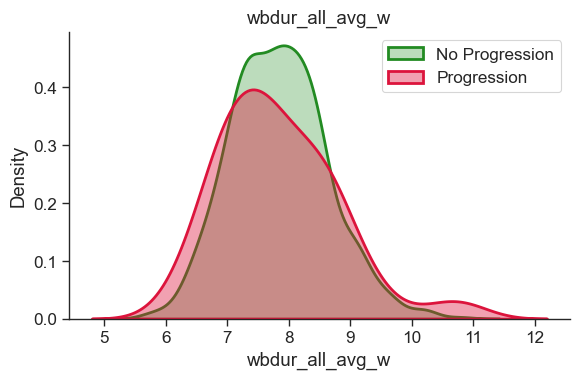

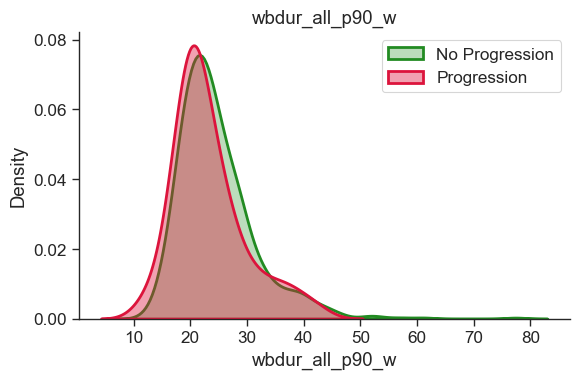

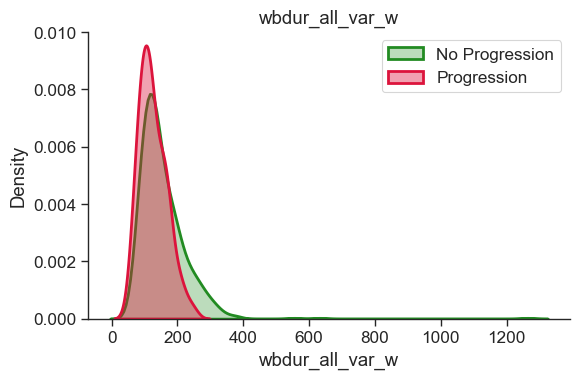

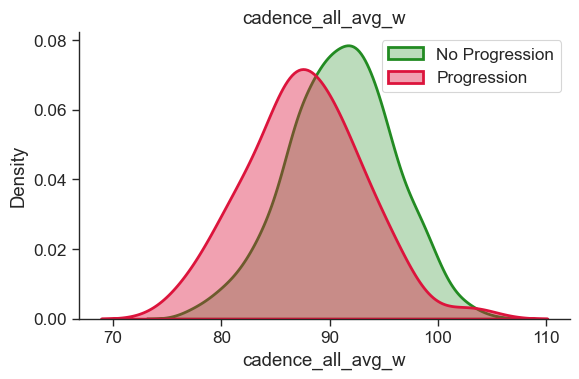

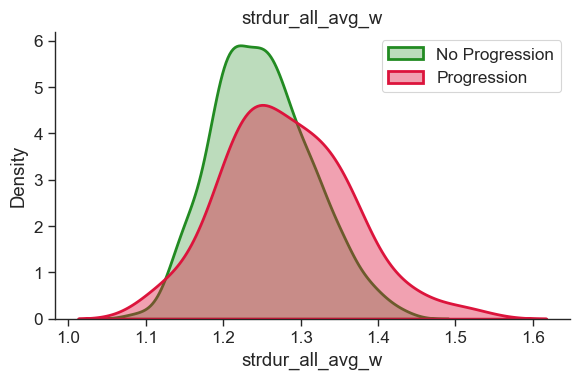

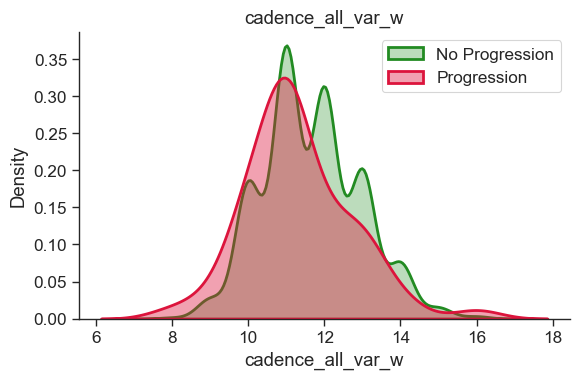

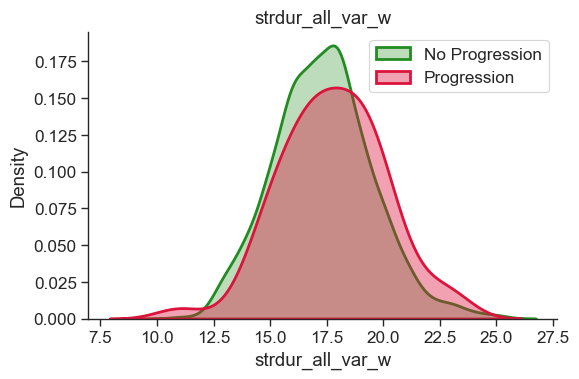

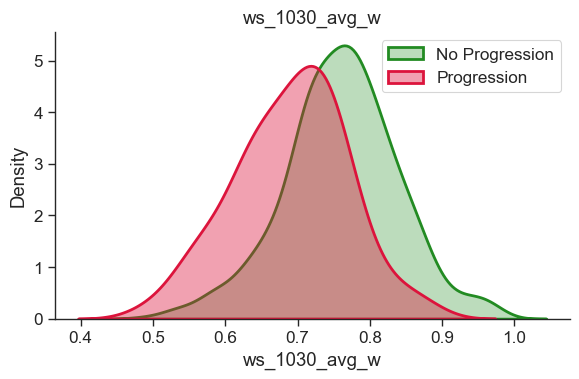

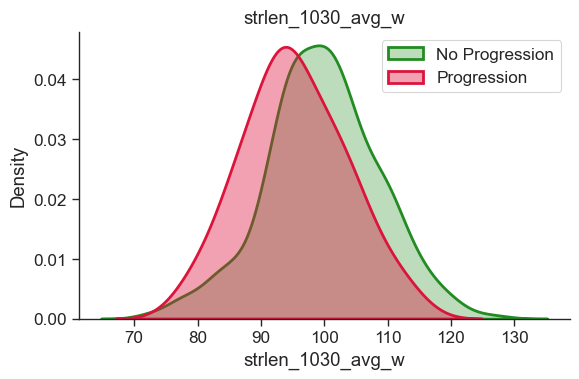

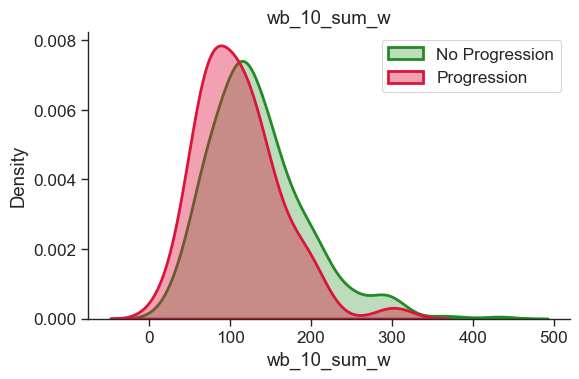

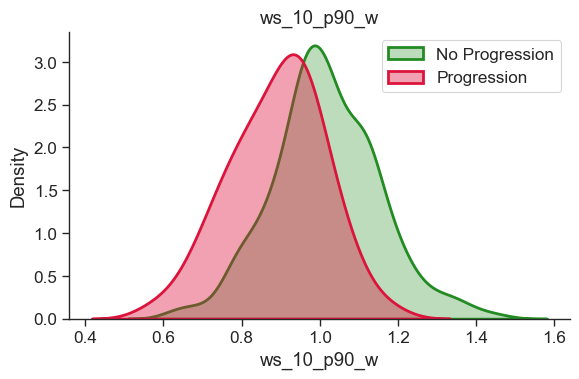

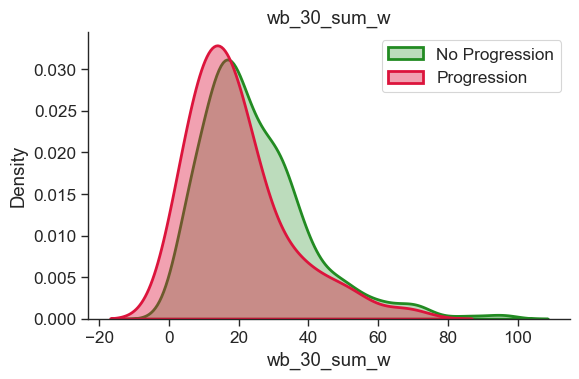

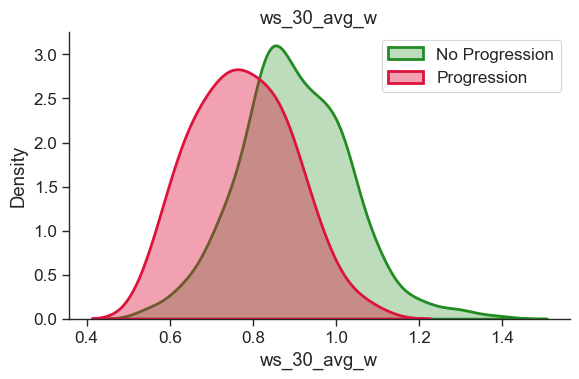

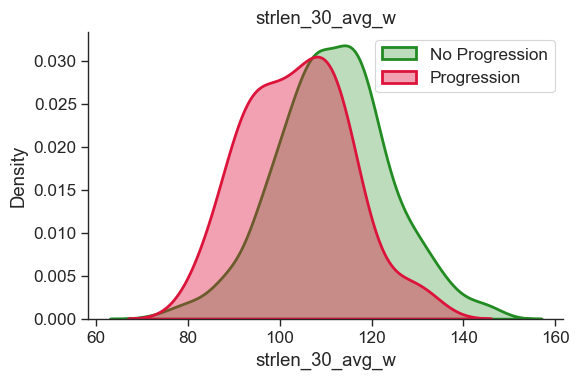

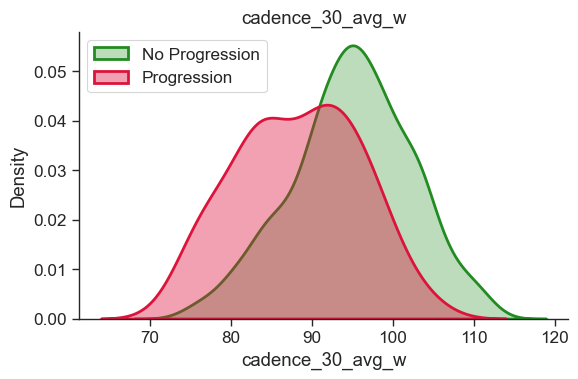

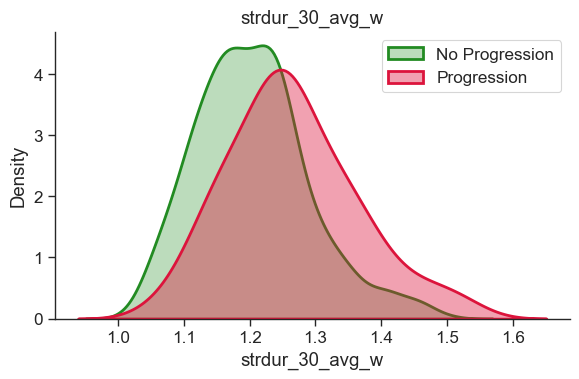

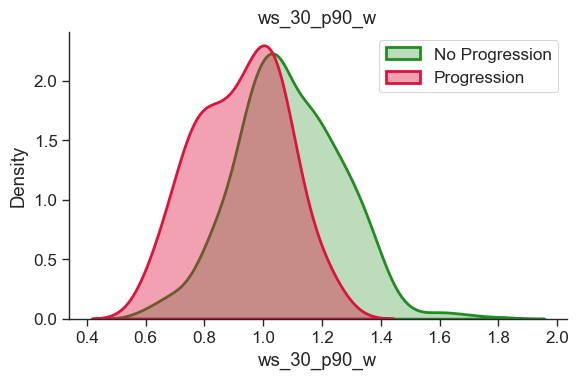

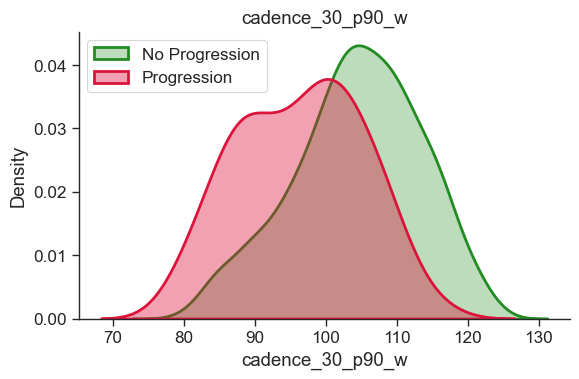

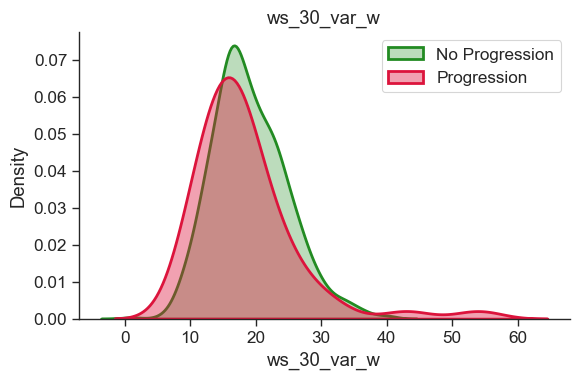

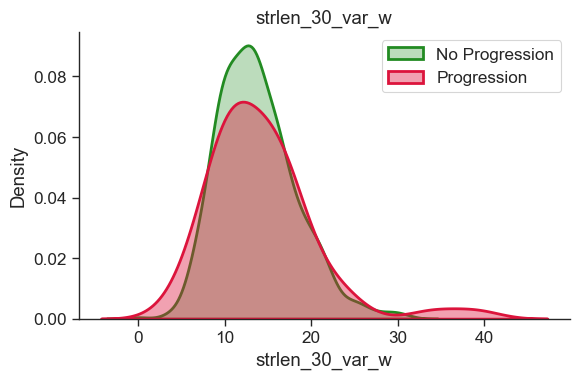

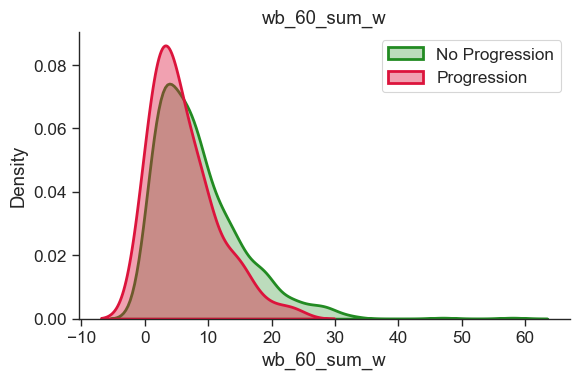

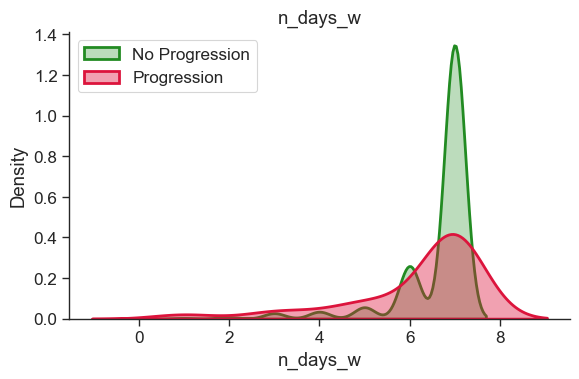

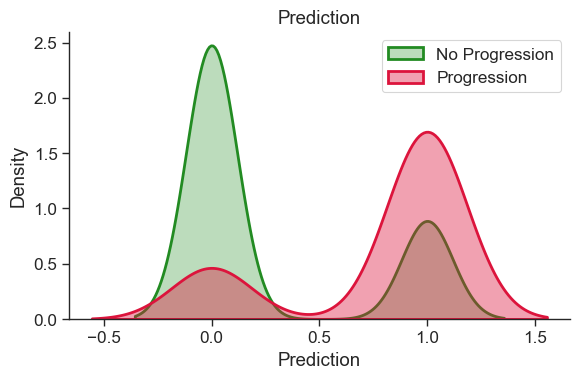

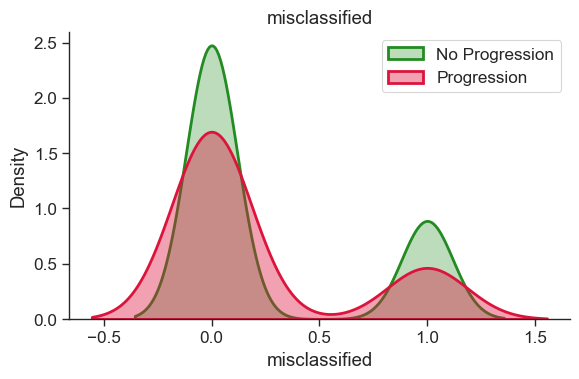

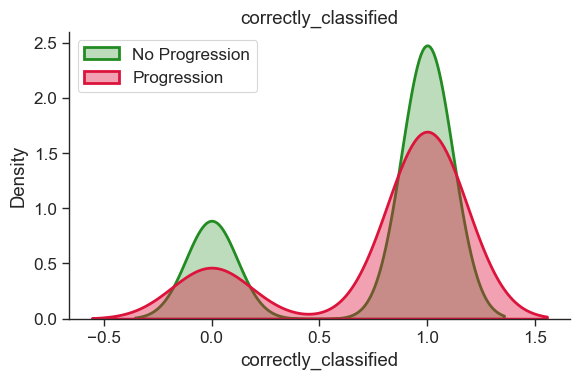

In [12]:
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.4)

prog_group = original_data_with_predictions[original_data_with_predictions["progression"] == 1]
no_prog_group = original_data_with_predictions[original_data_with_predictions["progression"] == 0]

feature_cols = [c for c in original_data_with_predictions.columns if c != "progression"]

for col in feature_cols:
    plt.figure(figsize=(6, 4))

    if pd.api.types.is_numeric_dtype(original_data_with_predictions[col]):

        sns.kdeplot(data=no_prog_group, x=col, fill=True,
                    color='forestgreen', label='No Progression', alpha=0.3, linewidth=2)
        sns.kdeplot(data=prog_group, x=col, fill=True,
                    color='crimson', label='Progression', alpha=0.4, linewidth=2)

        plt.ylabel('Density')
        plt.legend()

    else:
        temp_df = original_data_with_predictions.groupby('progression')[col].value_counts(normalize=True).rename(
            'proportion').reset_index()
        temp_df['progression_label'] = temp_df['progression'].map({0: 'No Progression', 1: 'Progression'})

        sns.barplot(data=temp_df, x=col, y='proportion', hue='progression_label',
                    palette={'No Progression': 'forestgreen', 'Progression': 'crimson'}, edgecolor='black')

        plt.ylabel('Proportion')
        plt.legend(title=None)

    plt.title(f'{col}')
    plt.xlabel(col)

    sns.despine()

    plt.tight_layout()
    plt.show()